In [1]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display
import scipy.signal
import os
import requests
import tarfile
from scipy.io import wavfile

# Download LJ Speech Dataset
!wget https://data.keithito.com/data/speech/LJSpeech-1.1.tar.bz2

# Extract only the first 30 WAV files
download_dir = "LJSpeech-1.1"
os.makedirs(download_dir, exist_ok=True)

with tarfile.open("LJSpeech-1.1.tar.bz2", "r:bz2") as file:
    count = 0
    for member in file.getmembers():
        if member.name.endswith(".wav") and count < 30:
            file.extract(member, path=".")
            count += 1
        if count >= 30:
            break

print(f"Downloaded 30 audio samples to: {download_dir}")



--2025-05-04 12:20:43--  https://data.keithito.com/data/speech/LJSpeech-1.1.tar.bz2
Resolving data.keithito.com (data.keithito.com)... 195.181.163.196, 2400:52e0:1a02::974:1
Connecting to data.keithito.com (data.keithito.com)|195.181.163.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2748572632 (2.6G) [text/plain]
Saving to: ‘LJSpeech-1.1.tar.bz2’

LJSpeech-1.1.tar.bz 100%[===================>]   2.56G  90.5MB/s    in 31s     

2025-05-04 12:21:15 (83.4 MB/s) - ‘LJSpeech-1.1.tar.bz2’ saved [2748572632/2748572632]

Downloaded 30 audio samples to: LJSpeech-1.1


In [5]:
# Select a sample file
sample_file = "/content/LJSpeech-1.1/wavs/LJ035-0056.wav"
signal, sr = librosa.load(sample_file, sr=16000)


In [7]:
import numpy as np
frame_size = int(sr * 0.03)
midpoint = len(signal) // 2
sample_frame = signal[midpoint : midpoint + frame_size]
hamming_window = np.hamming(len(sample_frame))
windowed_signal = sample_frame * hamming_window
fft_result = np.fft.fft(windowed_signal)
log_spectrum = np.log(np.abs(fft_result) + 1e-10)
real_cepstrum = np.fft.ifft(log_spectrum).real

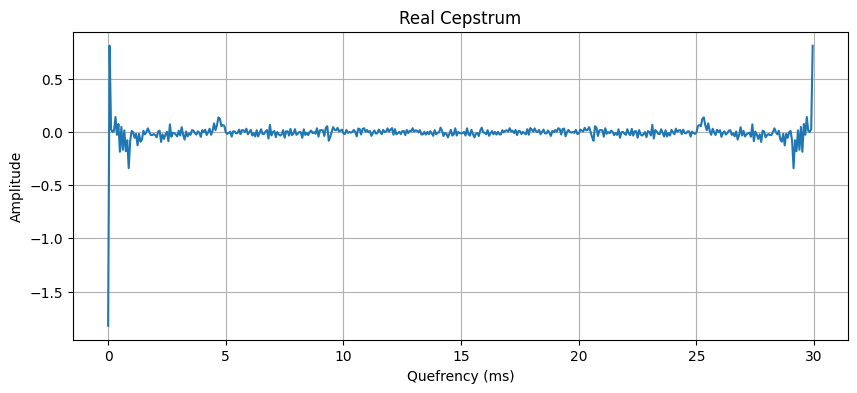

In [10]:
plt.figure(figsize=(10, 4))
quefrency = np.arange(len(real_cepstrum))/sr
plt.plot(quefrency * 1000, real_cepstrum)
plt.title("Real Cepstrum")
plt.xlabel("Quefrency (ms)")
plt.ylabel("Amplitude")
plt.grid()
plt.show()


In [11]:
def detect_voicing_via_cepstrum(audio_frame, sr, threshold=0.05):
    tapered_frame = audio_frame * np.hamming(len(audio_frame))
    freq_response = np.fft.fft(tapered_frame)
    log_magnitude = np.log(np.abs(freq_response) + 1e-10)
    cepstrum_vals = np.fft.ifft(log_magnitude).real
    lower_bound = int(0.005 * sr)
    upper_bound = int(0.020 * sr)
    peak_value = np.max(cepstrum_vals[lower_bound:upper_bound])
    return peak_value > threshold


In [13]:
if detect_voicing_via_cepstrum(windowed_signal, sr):
    print("Voiced frame found")
    quef_lo = int(0.005 * sr)
    quef_hi = int(0.020 * sr)
    dominant_index = np.argmax(real_cepstrum[quef_lo:quef_hi]) + quef_lo
    pitch_time = dominant_index / sr
    estimated_pitch = 1.0 / pitch_time
    print(f"Pitch period: {pitch_time * 1000:.2f} s")
    print(f"Estimated F0: {estimated_pitch:.2f} Hz")
else:
    print("Frame appears unvoiced — no dominant cepstral peak found")

Voiced frame found
Pitch period: 6.88 ms
Estimated F0: 145.45 Hz


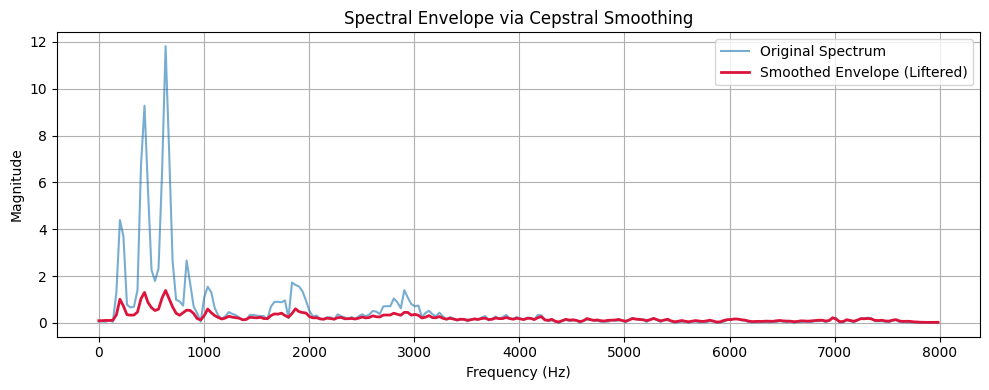

In [16]:
import matplotlib.pyplot as plt
import numpy as np
cutoff_idx = int(0.01 * sr)
cepstrum_envelope_only = np.copy(real_cepstrum)
cepstrum_envelope_only[cutoff_idx:] = 0
smoothed_log_spectrum = np.fft.fft(cepstrum_envelope_only).real
vocal_tract_envelope = np.exp(smoothed_log_spectrum)
log_spectrum_original = np.log(np.abs(fft_result) + 1e-10)
freq_axis = np.linspace(0, sr, len(vocal_tract_envelope))
plt.figure(figsize=(10, 4))
plt.plot(freq_axis[:len(vocal_tract_envelope)//2],
         np.exp(log_spectrum_original[:len(vocal_tract_envelope)//2]),
         label='Original Spectrum', alpha=0.6)
plt.plot(freq_axis[:len(vocal_tract_envelope)//2],
         vocal_tract_envelope[:len(vocal_tract_envelope)//2],
         label='Smoothed Envelope (Liftered)', color='crimson', linewidth=2)
plt.title("Spectral Envelope via Cepstral Smoothing")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()